## Modelling

In this notebook you will find the models that I chose to use and the evaluation of the models' performances. Model after model, I will provide a high level observation of the results. The primary classification metric is going be AUC. AUC has the advantage of not being affected by class imbalance. 
Last but not least, we'll also the models' investigate learning curves.

** Modelling: **
- Logistic regression
- Nearest Neighbors
- Decision Trees
- Ensemble decision trees (Bagging and Boosting)

** Evaluation: **
- ROC


## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import feature_selection
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from  cross_val_tool import cross_validation

In [72]:
loans = pd.read_csv("/Users/Hedi/Documents")
del loans['Unnamed: 0']
del loans['earliest_cr_line']
del loans['loan_status']

In [3]:
list_of_parameters = [col for col in loans.columns if col not in ['id','loan_perf']]

In [4]:
ss = StandardScaler()
rs = RobustScaler()

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(loans[list_of_parameters], 
                                                    loans['loan_perf'], test_size=0.25, 
                                                    stratify= loans['loan_perf'],random_state=1234)

In [6]:
# Normalize
# Standard Scaler
X_train_scaled_ss = ss.fit_transform(X_train)
X_test_scaled_ss = ss.fit_transform(X_test)

# Robust Scaler
X_train_scaled_rs = rs.fit_transform(X_train)
X_test_scaled_rs = rs.fit_transform(X_test)

In [7]:
def roc_plot(y_preds):
    """
    Input:
    -------
    y_preds - Series of predicted values from the test dataset
    
    Output:
    -------
    Plot of the ROC curve and AUC value in the legend
    """
    fpr, tpr, threshold = roc_curve(y_test.values, y_preds)
    roc_auc = auc(fpr, tpr)
    tn, fp, fn, tp = confusion_matrix(y_test.values,y_preds).ravel()
    true_pred = sum([tn,tp])
    plt.figure(figsize=(11,9))
    # plot
    plt.plot(fpr, tpr, label='ROC curve of class = {0:0.2f}'.format(roc_auc))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve of the classifier')
    plt.legend(loc="lower right")
    return plt.show()

In [8]:
def plot_feat_import_DT(fitted_model):
    """
    Input:
    ------
    Fitted Decision Tree model
    Output:
    ------
    Plot of the feature importance in an ordered manner
    """
    
    # create array of feature names for ploting
    # call the array field_names
    field_names = X_test.columns.values

    # create array of feature importance weights
    # call the array feat_weights
    feat_weights = fitted_model.feature_importances_

    # use np.argsort to get an array of ordered indicies that can be used to 
    # sort feature importance weights from largest to smallest
    # call the array indices
    indices = np.argsort(feat_weights)[::-1]

    # create an int variable call n_features that is the numer of features in the feature set
    n_features = len(feat_weights)

    tick_marks_list = list(range(len(field_names)))

    # create an array of sorted feature names
    # call the array sorted_feat_names
    sorted_feat_names =  np.array(field_names)[indices]


    # create an array of sorted feature weights
    # call the array sorted_feat_weights
    sorted_feat_weights = feat_weights[indices]
    
    plt.figure(figsize=(15,5))
    plt.title("Feature Importances")
    plt.ylabel("Information Gain")
    plt.bar(list(range(15)), sorted_feat_weights[:15],align="center",color="g",alpha=0.5)
    plt.xticks(tick_marks_list, sorted_feat_names, rotation=15)
    plt.xlim([-1, 10])
    #plt.ylim([0,0.03])
    #plt.savefig('RF_FI.pdf')
    return plt.show()

In [9]:
def plot_feat_import_RF(fitted_model):
    """
    Input:
    ------
    Fitted Random Forest model
    Output:
    ------
    Plot of the feature importance in an ordered manner
    """
    
    # create array of feature names for ploting
    # call the array field_names
    field_names = X_test.columns.values

    # create array of feature importance weights from Random Forest
    # call the array feat_weights
    feat_weights = fitted_model.feature_importances_

    # use np.argsort to get an array of ordered indicies that can be used to 
    # sort feature importance weights from largest to smallest
    # call the array indices
    indices = np.argsort(feat_weights)[::-1]

    # Create a list comprehension that collects the feature importance values for every tree in the RF ensemble
    # Hint: Use rfc.estimators_
    # call the list feat_importance_trees
    feat_importance_trees = [tree.feature_importances_ for tree in fitted_model.estimators_]

    # take the standard deviation of this list, this resulting list is the std value for each feature 
    # call the array std
    std = np.std(feat_importance_trees, axis=0) # std along the column

    # create an int variable call n_features that is the numer of features in the feature set
    n_features = len(feat_weights)

    tick_marks_list = list(range(len(field_names)))

    # create an array of sorted feature names
    # call the array sorted_feat_names
    sorted_feat_names =  np.array(field_names)[indices]

    # create an array of soreted std 
    # call the array sorted_std
    sorted_std = std[indices]

    # create an array of sorted feature weights
    # call the array sorted_feat_weights
    sorted_feat_weights = feat_weights[indices]
    
    plt.figure(figsize=(15,5))
    plt.title("Feature Importances")
    plt.ylabel("Information Gain")
    plt.bar(list(range(15)), sorted_feat_weights[:15],align="center",color="g",alpha=0.5)
    plt.xticks(tick_marks_list, sorted_feat_names, rotation=15)
    plt.xlim([-1, 10])
    #plt.ylim([0,0.03])
    #plt.savefig('RF_FI.pdf')
    return plt.show()

In [10]:
def plot_feat_import_GB(fitted_model):
    """
    Input:
    ------
    Fitted Gradient Boosting model
    Output:
    ------
    Plot of the feature importance in an ordered manner
    """
    
    # create array of feature names for ploting
    # call the array field_names
    field_names = X_test.columns.values

    # create array of feature importance weights
    # call the array feat_weights
    feat_weights = fitted_model.feature_importances_

    # use np.argsort to get an array of ordered indicies that can be used to 
    # sort feature importance weights from largest to smallest
    # call the array indices
    indices = np.argsort(feat_weights)[::-1]


    # create an int variable call n_features that is the numer of features in the feature set
    n_features = len(feat_weights)

    tick_marks_list = list(range(len(field_names)))

    # create an array of sorted feature names
    # call the array sorted_feat_names
    sorted_feat_names =  np.array(field_names)[indices]


    # create an array of sorted feature weights
    # call the array sorted_feat_weights
    sorted_feat_weights = feat_weights[indices]
    
    plt.figure(figsize=(15,5))
    plt.title("Feature Importances")
    plt.ylabel("Information Gain")
    plt.bar(list(range(15)), sorted_feat_weights[:15],align="center",color="g",alpha=0.5)
    plt.xticks(tick_marks_list, sorted_feat_names, rotation=15)
    plt.xlim([-1, 10])
    #plt.ylim([0,0.03])
    #plt.savefig('RF_FI.pdf')
    return plt.show()

In [11]:
def significance_(cols):
    if cols['p_value_rating']<0.001:
        return '***'
    if cols['p_value_rating']<0.01:
        return '**'
    if cols['p_value_rating']<0.1:
        return '*'
    else:
        return ''

In [12]:
def get_features_for_each_target(fitted_model):
    
    """
    Input:
    ------
    fitted_model: already fitted model with X_train and y_train
    
    Output:
    ------
    dataframe of the features and its weights
    """
    
    c=feature_selection.f_classif(X_train,y_train.values)[1].tolist()
    summary=pd.concat([pd.DataFrame(data=np.transpose(abs(fitted_model.feature_importances_)),index=X_train.columns,
                                columns=['Coef_rating']), pd.DataFrame(c,index=X_train.columns,columns=['p_value_rating'])], axis=1)
    summary['significance']=pd.DataFrame(summary.apply(significance_,axis=1))
    
    df_features = summary.sort_values(by='p_value_rating',ascending=True)
    return df_features

# ----------------------------------------------------
## 1) Baseline models for Classification
** Naive Bayes Model: **
Most basic model to perform classification prediction. The naive attribute comes from the assumption that each feature independently provide the same weight. We will assume normal distribution. 

** Logistic Regression: **
Linear model that allows to embrace linear relationship between parameter and a dichotomous target.

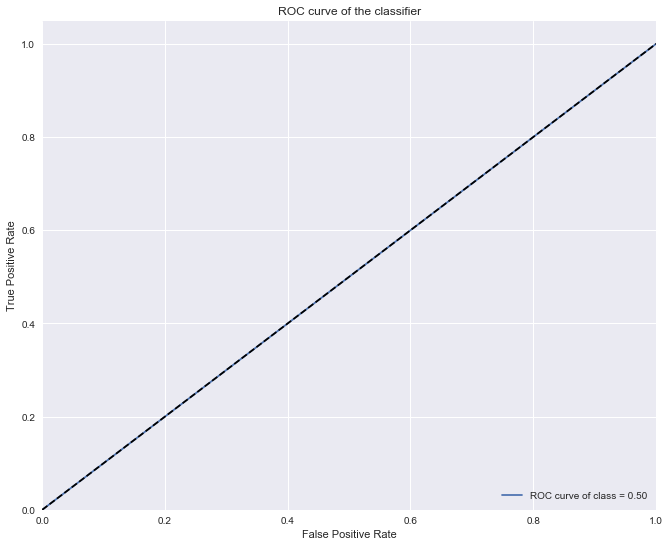

In [13]:
# Naive Bayes model
gnb = GaussianNB()
gnb_fitted = gnb.fit(X_train_scaled_ss, y_train.values)

y_hat_gnb = gnb_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_gnb)


### The Naive Bayes model results in a AUC = 50% -> We need to implement more complex algorithms
    The AUC provided by the Naive Bayes Model is exactly equal to 50% meaning that it is equivalent
    to a model that would RANDOMLY predict the loan performance.

In [14]:
# Logistic Regression
lr = LogisticRegression()
lr_params = {'penalty' : ['l1','l2']}

lr_best = GridSearchCV(lr, 
                        param_grid=lr_params , 
                        n_jobs=2)
lr_best.fit(X_train_scaled_ss,y_train.values)
lr_best.best_params_

{'penalty': 'l1'}

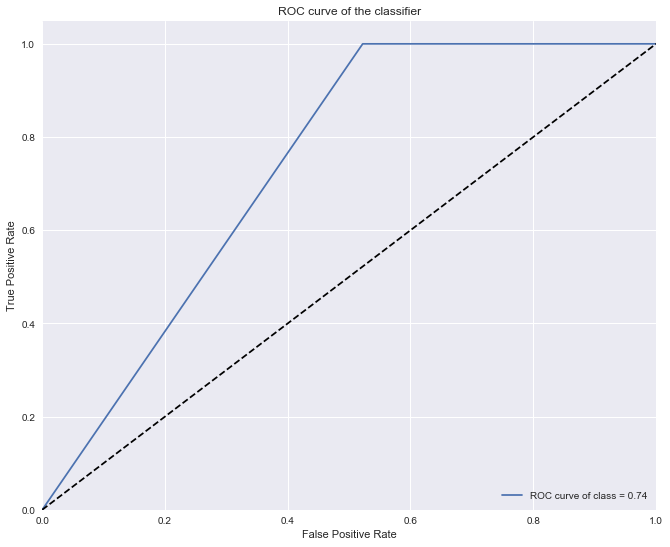

In [16]:
lr_optmized = LogisticRegression(penalty='l1')
lr_fitted = lr_optmized.fit(X_train_scaled_ss,y_train.values)

y_hat_lr = lr_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_lr)

### The Logistic Regression model results in a AUC = 74% 
    Logistic regression clearly performs better than Naive bayes model

In [40]:
learning_LR = cross_validation(lr, 
                                X_train_scaled_ss, 
                                y_train.values, 
                                n_splits=5, 
                                init_chunk_size = 1000, 
                                chunk_spacings = 1000)

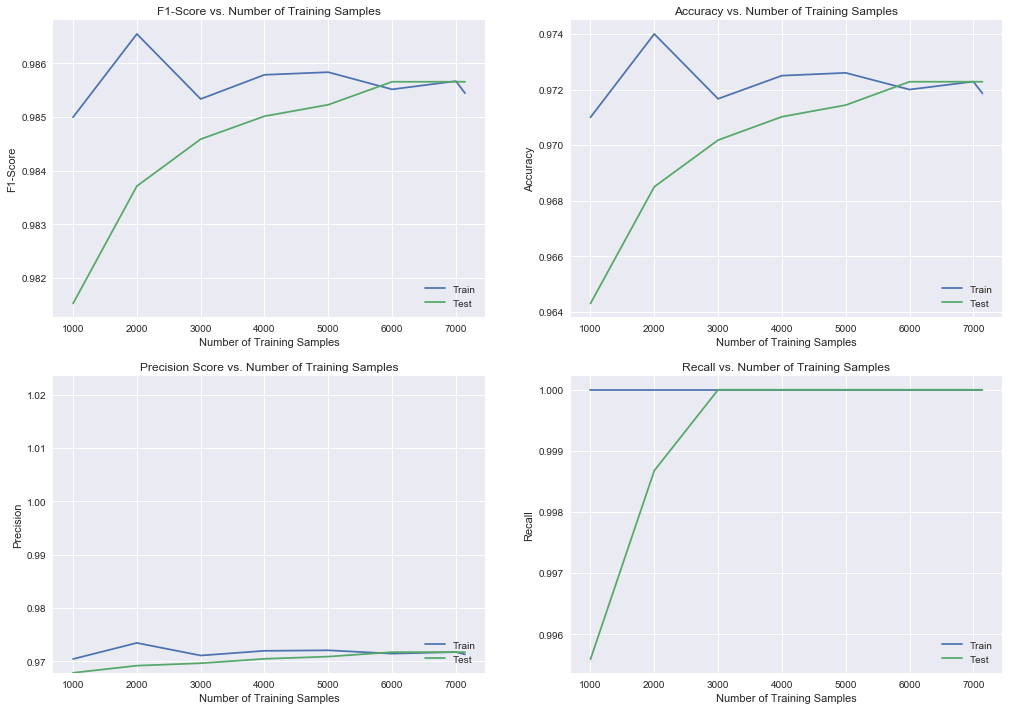

In [41]:
learning_LR.validate_for_holdout_set(X_test_scaled_ss, y_test.values)
learning_LR.plot_learning_curve(image_name="LR_Learning_Curve")

# ----------------------------------------------------
## 2) Nearest Neighbors Classifier
** K-Nearest Neighbors: **
Algorithms that uses k-nearest neighbors voting methodology. K-Neighrest neighbors uses a voting methodology from the n neighbors surrounding the point to determine the points class. Since we are in presence of a high class imbalance we shall only look at few point close to the point of interest.

Note that, K-nearest neighbors algorithm usually breaks when the number of features is very high due to the curse of dimensionality.

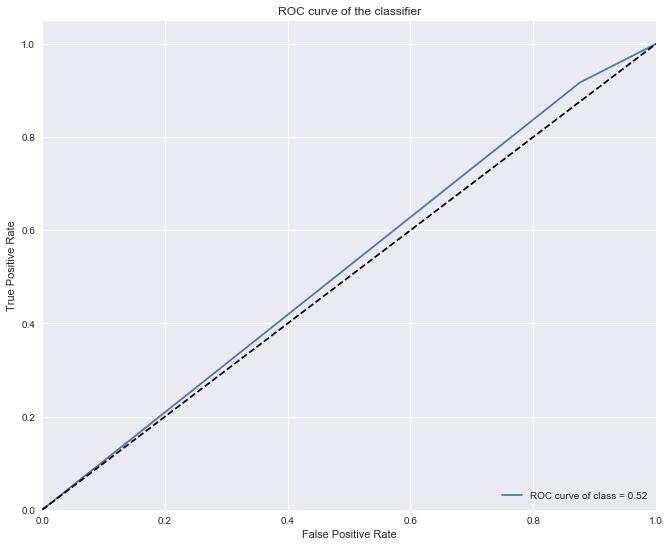

In [20]:
# K-Nearest Neighbor classifier
knc = KNeighborsClassifier(n_neighbors=2)
knc_fitted = knc.fit(X_train_scaled_ss, y_train.values)

y_hat_knc = knc_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_knc)

### KNN model results in a AUC = 52% 
    Hypothesis: The bad performance may be attributed to the curse of dimensionality (high dimensionality)

# -------------------------------------------------
## 3) Ensemble Methods using Decision Trees
** Decision Tree Classifier: **
I expect a single decision tree classifier to perform very well on the training set but not so well on the test set. In fact, a decision tree max depth usually overfits the data. 

** Bagging with RandomForest Classifier: **
Classifier that consists of numerous (deep) decision trees and the output is computed with a vote.
Very efficient with large datasets and variables. Smaller datasets may jeopardize its the generalization to unseen datasets (with different distributions)

** Boosting with GradientBoosting Classifier: **
Classifier that consists of numerous shallow decision trees where each successive tree is built for the prediction residuals of the preceding tree. In essence, it learns from the previous tree, in order to construct the succeeding one so that the misclassification of cases is minimized (Dursun et al. 2008)

** Hypothesis: **
Both methods shall lead to satisfactory results. However, their generalization to unseen datasets (with different) distributions may be jeopardized because of the training data small size.

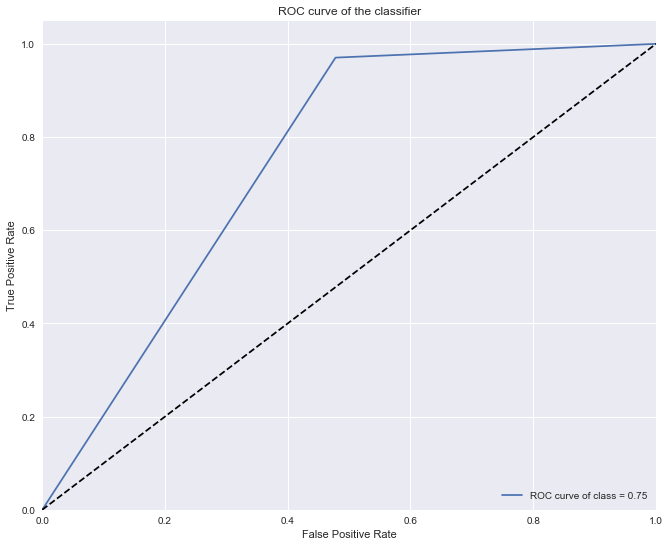

In [21]:
# Decision Tree classifier
dtc = DecisionTreeClassifier()
dtc_fitted = dtc.fit(X_train_scaled_ss, y_train.values)

y_hat_dtc = dtc_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_dtc)

In [22]:
get_features_for_each_target(dtc_fitted).head()

,Coef_rating,p_value_rating,significance
out_prncp,0.085782,2.536878e-20,***
int_rate,0.023176,4.301145e-13,***
annual_inc,0.025734,5.228452e-09,***
total_rec_prncp,0.312231,7.828371e-09,***
dti,0.043561,7.060247e-06,***


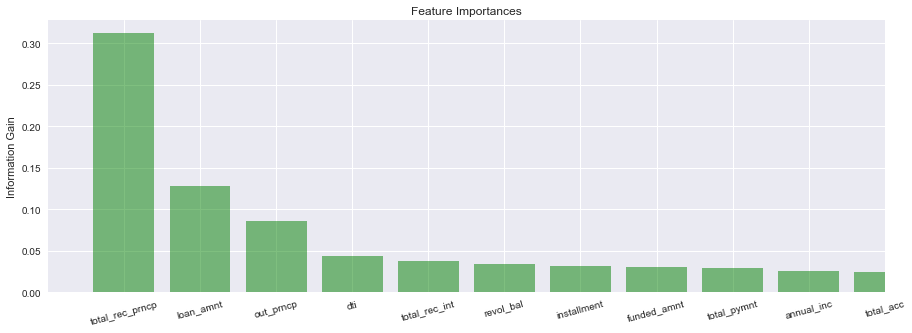

In [23]:
plot_feat_import_DT(dtc_fitted)

In [44]:
learning_DT = cross_validation(dtc, 
                                X_train_scaled_ss, 
                                y_train.values, 
                                n_splits=5, 
                                init_chunk_size = 1000, 
                                chunk_spacings = 1000, 
                                average = "macro")

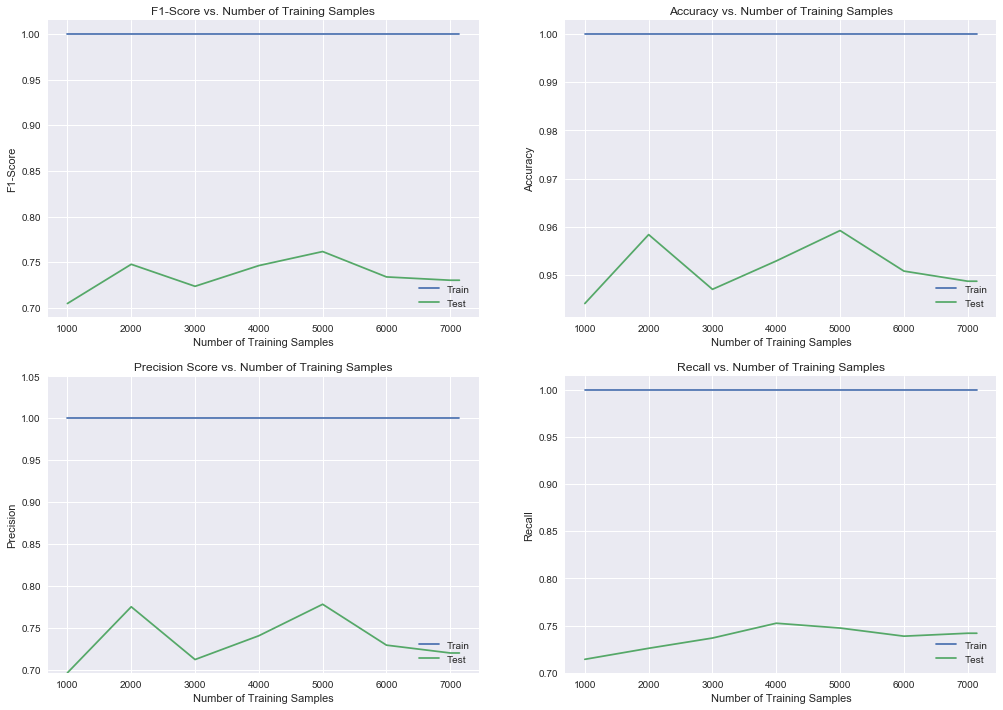

In [45]:
learning_DT.validate_for_holdout_set(X_test_scaled_ss, y_test.values)
learning_DT.plot_learning_curve(image_name="DT_Learning_Curve")

## ----------------------------------------------------

In [26]:
# Random Forest Classifier
rfc = RandomForestClassifier()
rfc_params = {'n_estimators' : [100,500],'criterion':['gini','entropy']}

rfc_best = GridSearchCV(rfc, 
                        param_grid=rfc_params , 
                        n_jobs=2)
rfc_best.fit(X_train,y_train.values)
rfc_best.best_params_

{'criterion': 'entropy', 'n_estimators': 500}

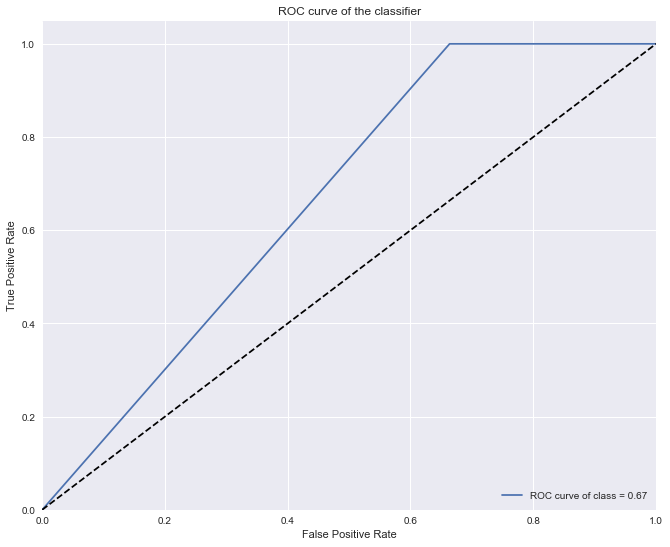

In [27]:
rfc_optmized = RandomForestClassifier(criterion='entropy', n_estimators= 500)
rfc_fitted = rfc_optmized.fit(X_train_scaled_ss,y_train.values)

y_hat_rfc = rfc_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_rfc)

In [28]:
get_features_for_each_target(rfc_fitted).head(15)

,Coef_rating,p_value_rating,significance
out_prncp,0.148514,2.536878e-20,***
int_rate,0.051588,4.301145e-13,***
annual_inc,0.053787,5.228452e-09,***
total_rec_prncp,0.093005,7.828371e-09,***
dti,0.049510,7.060247e-06,***
home_ownership_RENT,0.007176,2.459524e-05,***
total_pymnt,0.072385,3.399358e-05,***
home_ownership_MORTGAGE,0.006745,3.433116e-05,***
addr_state_UT,0.004027,1.678262e-04,***
purpose_small_business,0.003952,1.742837e-04,***


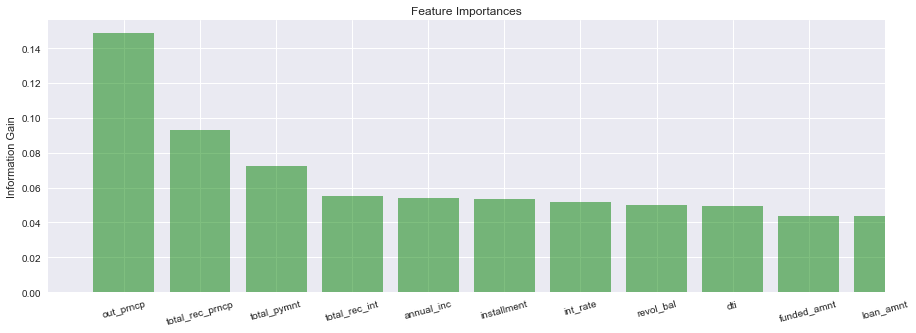

In [29]:
plot_feat_import_RF(rfc_fitted)

In [30]:
learning_RF = cross_validation(rfc_optmized, 
                                X_train_scaled_ss, 
                                y_train.values, 
                                n_splits=5, 
                                init_chunk_size = 1000, 
                                chunk_spacings = 1000, 
                                average = "macro")

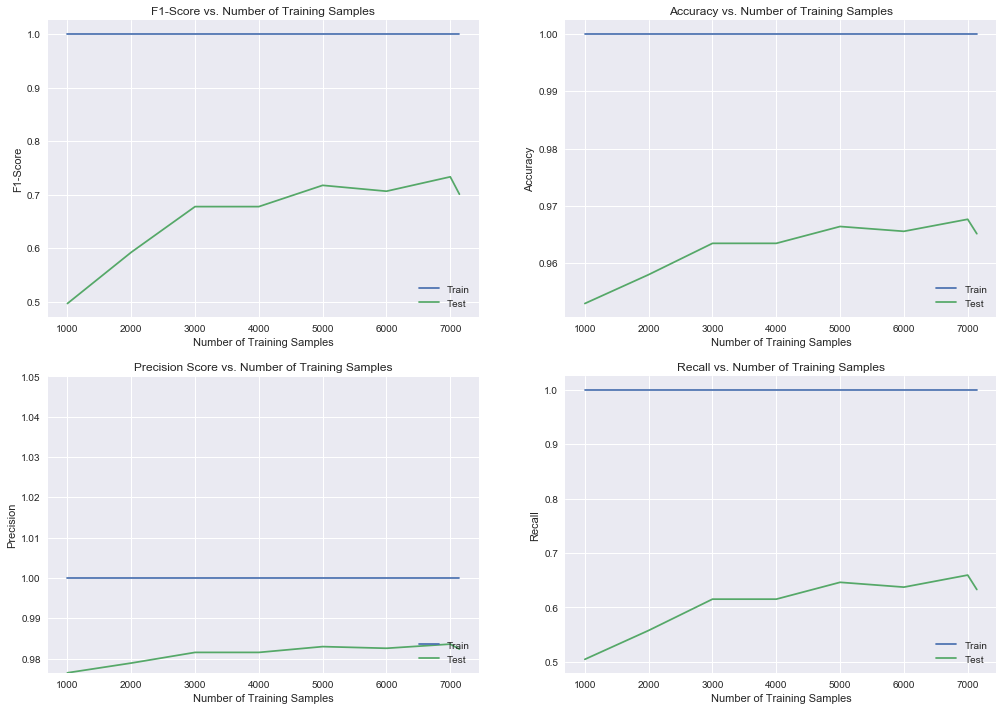

In [31]:
learning_RF.validate_for_holdout_set(X_test_scaled_ss, y_test.values)
learning_RF.plot_learning_curve(image_name="RF_Learning_Curve")

## ----------------------------------------------------

In [32]:
# Gradient Boosting Classifier
gbc = GradientBoostingClassifier()
gbc_params = {'n_estimators' : [100,500], 'learning_rate':[0.1,1]}
gbc_best = GridSearchCV(gbc, 
                        param_grid=gbc_params , 
                        n_jobs=2)
gbc_best.fit(X_train,y_train.values)
gbc_best.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

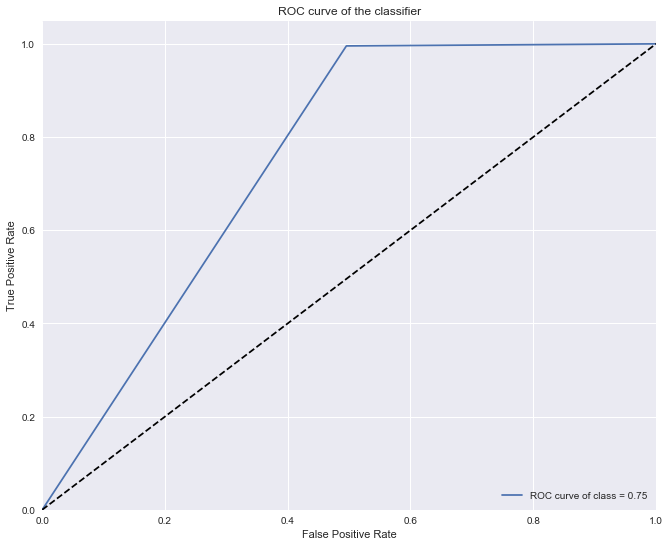

In [33]:
gbc_optmized = GradientBoostingClassifier(learning_rate= 0.1, n_estimators= 500)
gbc_fitted = gbc_optmized.fit(X_train_scaled_ss,y_train.values)
y_hat_gbc = gbc_fitted.predict(X_test_scaled_ss)
roc_plot(y_hat_gbc)

In [34]:
get_features_for_each_target(gbc_fitted).head(15)

,Coef_rating,p_value_rating,significance
out_prncp,0.086692,2.536878e-20,***
int_rate,0.029158,4.301145e-13,***
annual_inc,0.056978,5.228452e-09,***
total_rec_prncp,0.099732,7.828371e-09,***
dti,0.081588,7.060247e-06,***
home_ownership_RENT,0.003457,2.459524e-05,***
total_pymnt,0.066424,3.399358e-05,***
home_ownership_MORTGAGE,0.001910,3.433116e-05,***
addr_state_UT,0.007711,1.678262e-04,***
purpose_small_business,0.008403,1.742837e-04,***


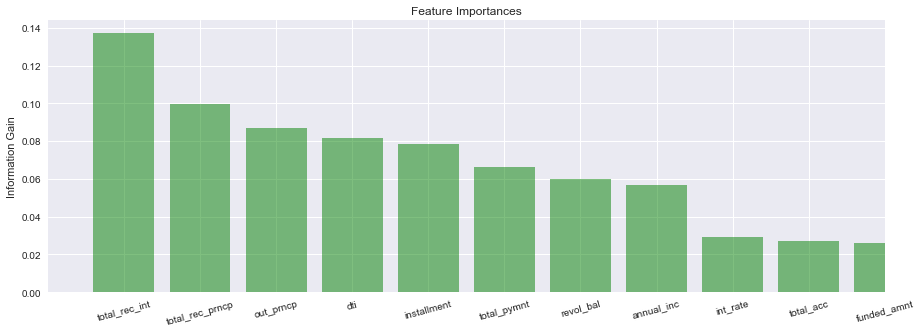

In [35]:
plot_feat_import_GB(gbc_fitted)

In [36]:
learning_GB = cross_validation(gbc_optmized, 
                                X_train_scaled_ss, 
                                y_train.values, 
                                n_splits=5, 
                                init_chunk_size = 1000, 
                                chunk_spacings = 1000, 
                                average = "macro")

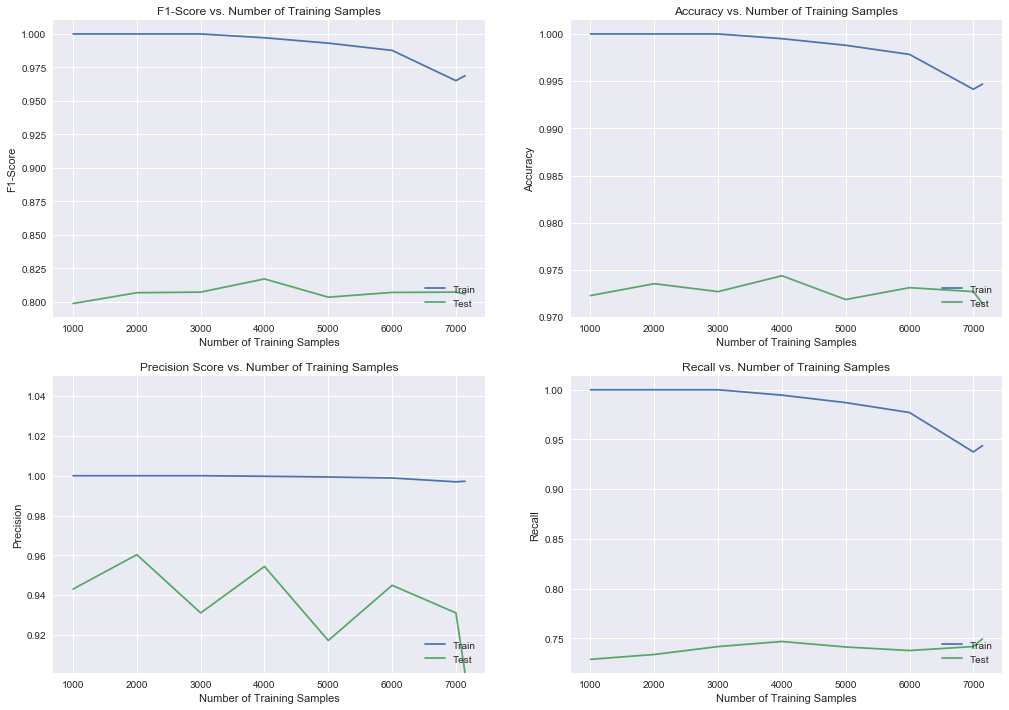

In [37]:
learning_GB.validate_for_holdout_set(X_test_scaled_ss, y_test.values)
learning_GB.plot_learning_curve(image_name="GB_Learning_Curve")

## ----------------------------------------------------
** Summarizing ROC curves: **

Accuracy of prediction is 0.952540949181
The Naive Bayes model is learning something about the predicting process.
It predicted correctly 2268 out of 2381 instances. 
Accuracy of prediction is 0.97522049559
The LogReg model is learning something about the predicting process.
It predicted correctly 2322 out of 2381 instances. 
Accuracy of prediction is 0.879462410752
The KNN model is learning something about the predicting process.
It predicted correctly 2094 out of 2381 instances. 
Accuracy of prediction is 0.94918101638
The Decision Tree model is learning something about the predicting process.
It predicted correctly 2260 out of 2381 instances. 
Accuracy of prediction is 0.968500629987
The RandForest model is learning something about the predicting process.
It predicted correctly 2306 out of 2381 instances. 
Accuracy of prediction is 0.972280554389
The GradBoost model is learning something about the predicting process.
It predicted correctly 2315 out of 2381 instances. 


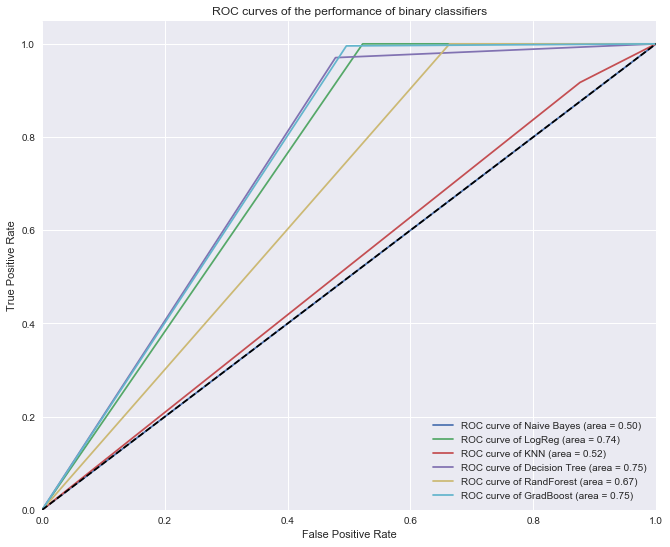

In [39]:
fpr = dict()
tpr = dict()
tp = dict()
tn = dict()
true_pred = dict()
y_preds = [y_hat_gnb, y_hat_lr, y_hat_knc, y_hat_dtc, y_hat_rfc, y_hat_gbc]
name_models = ['Naive Bayes','LogReg','KNN','Decision Tree', 'RandForest', 'GradBoost']
roc_auc = dict()
accuracy_model = dict()
class_imbalance = dict()

for i in range(len(y_preds)):
    fpr[i], tpr[i], threshold = roc_curve(y_test.values, y_preds[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    tn[i], fp, fn, tp[i] = confusion_matrix(y_test.values, y_preds[i]).ravel()
    true_pred[i] = sum([tn[i],tp[i]])

for i in range(len(y_preds)):
    accuracy_model[i] = accuracy_score(y_test.values, y_preds[i])
    class_imbalance[i] = 1 - float(sum(y_test.values))/float(len(y_test.values))
    print 'Accuracy of prediction is {}'.format(accuracy_model[i])
    if class_imbalance[i] > accuracy_model[i]:
        print 'The model is doing worse than if it would only predict the majoritary class all the time.\n============================================================'
    else:
        print 'The {} model is learning something about the predicting process.'.format(name_models[i])
        print 'It predicted correctly {0} out of {1} instances. \n============================================================'.format(true_pred[i],y_test.shape[0])

# Plot ROC curve
plt.figure(figsize=(11,9))
for i in range(len(y_preds)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of {0} (area = {1:0.2f})'.format(name_models[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves of the performance of binary classifiers')
plt.legend(loc="lower right")
plt.show()

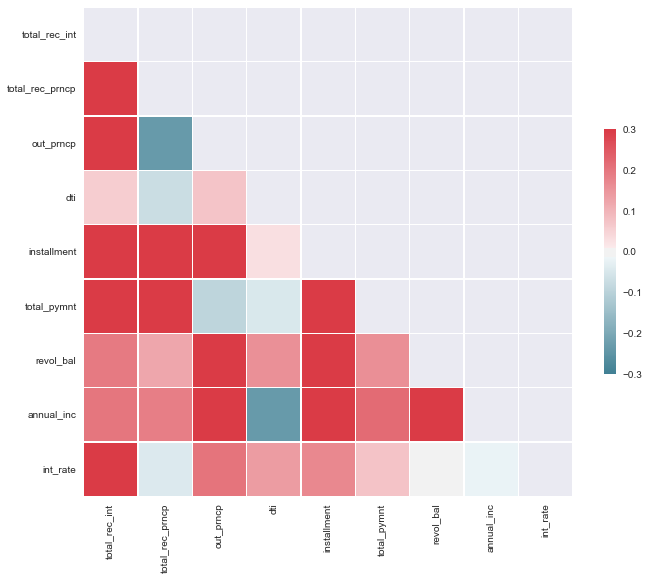

In [52]:
# Let's investigate the correlation between the best parameters that allow me to predict the loan performance›

corr = loans[['total_rec_int','total_rec_prncp','out_prncp','dti',
              'installment','total_pymnt','revol_bal','annual_inc','int_rate']].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [55]:
# Let's have a look at the prediction in more details
Conf_matrix = confusion_matrix(y_test,y_hat_gbc)

TN = Conf_matrix [0][0]
FN = Conf_matrix [1][0]
FP = Conf_matrix [0][1]
TP = Conf_matrix [1][1]

total_pop = TN + FN + FP + TP

In [71]:
# Let's quantify how much a False negative impact our revenue:
# Assuming that the revenue stream only comes from interest rates
avg_interest_rate = np.mean(loans[loans['loan_perf']==1]['int_rate'])
avg_funded_amount = np.mean(loans[loans['loan_perf']==1]['funded_amnt'])
total_loss_in_revenue_year = FN*avg_interest_rate*avg_funded_amount/100.00
print "the loss in revenue per year due to loans falsely categorized as being bad is {} USD"\
                                                                .format(round(total_loss_in_revenue_year))

the loss in revenue per year due to loans falsely categorized as being bad is 20319.0 USD


In [85]:
# Let's quantify how much a False Positive impact our revenue:
# Assuming that when loans default, they default without paying a dime back of their loan
default_percentage_dataset = round((loans[loans['loan_status'] == 'Default']['funded_amnt']).shape[0]*100.00\
                                   /loans[loans['loan_perf'] == 0].shape[0])
avg_loan_amnt_defaulted = np.mean(loans[loans['loan_status'] == 'Default']['funded_amnt'])

nbr_defaulted_loan_from_prediction = default_percentage_dataset*FP/100.00

loss_only_generated_by_defaulted_loans = round(round(default_percentage_dataset*FP/100.00) *avg_loan_amnt_defaulted)

print "The loss per year only generated by defaulted loans among the loans that we falsely predicted \
as GOOD is {} USD.".format(round(loss_only_generated_by_defaulted_loans))

The loss per year only generated by defaulted loans among the loans that we falsely predicted as GOOD is 35153.0 USD.


** False Negatives: **

False Negative are loans that my model predicted as BAD while they were GOOD.
In a situation where we could get rid of the predicted 10 BAD loans, these False Negative loans would be a loss in our profit because we would be rejected current or fully paid loans.

** False Positives: **

False Positive are loans that my model predicted as GOOD while they were BAD.
In a situation where we keep the predicted 56 GOOD loans, these False Positive loans would cause a loss because they are categorized as default, in grace period, or late.

** Conclusion: **

Both of these errors directly impact the profit of our business. The False negative decrease our revenue whereas the false positive increase our cost. Future work should be done to minimize Type 1 error (meaning Precision) by reducing the false positive. In fact, we saw that the impact of only defaulting loans present in the loans that we falsely predicted as GOOD generate over 35k of losses. (assuming that when a loan default, all of its funded amount is lost. 